<a href="https://colab.research.google.com/github/CamilaaRodriguezz/Laboratorio-5-Procesamiento-de-se-ales/blob/main/Laboratorio_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Leído con separador '\s+' -> 2809000 muestras numéricas.
Archivo cargado correctamente.
Primeras 5 muestras (tiempo, volt): [(np.float64(0.0), np.float64(1.578577)), (np.float64(0.0001), np.float64(1.57922)), (np.float64(0.0002), np.float64(1.580186)), (np.float64(0.0003), np.float64(1.579542)), (np.float64(0.0004), np.float64(1.580508))]
Últimas 5 muestras (tiempo, volt): [(np.float64(280.8995), np.float64(1.148868)), (np.float64(280.8996), np.float64(1.146293)), (np.float64(280.8997), np.float64(1.144683)), (np.float64(280.8998), np.float64(1.140499)), (np.float64(280.8999), np.float64(1.138246))]
Min/Max voltaje: 0.0329, 3.1848
fs aproximado = 10000.00 Hz (dt mediano = 0.000100 s)
Decimando por factor 40 para bajar a ~250.0 Hz (mejor para ECG).
Filtro aplicado (Butterworth bandpass).
Picos R detectados (método=pan_tompkins): 466
Mean RR = 0.603s, SDNN = 0.078s, SD1=0.07564571689294838, SD2=0.07956075213278353


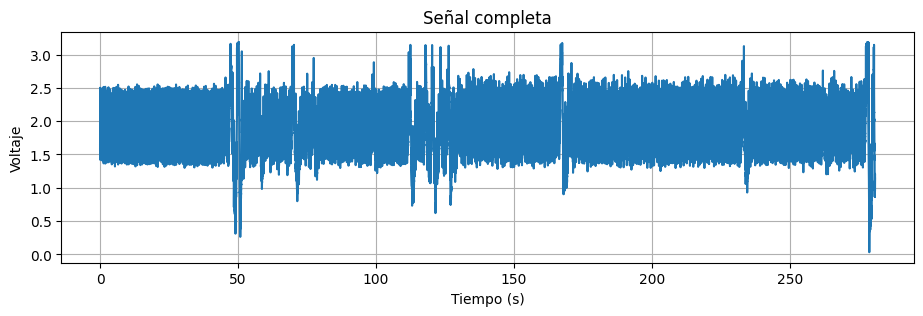

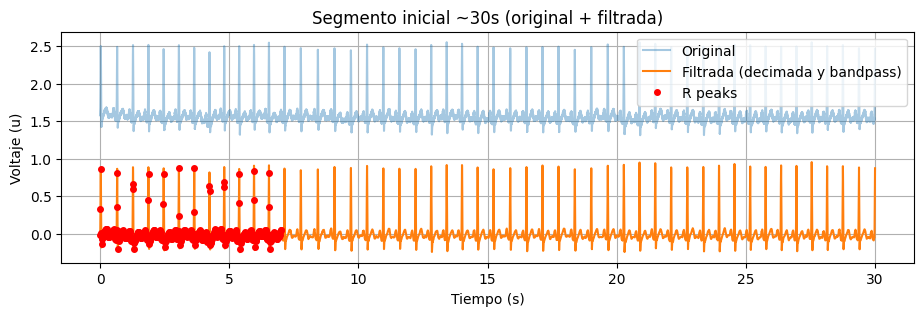

Resultados guardados en /content/hrv_output


,fs_original_Hz,fs_proc_Hz,num_samples_original,num_samples_proc,num_r_peaks,mean_rr_s,sdnn_s,sd1_s,sd2_s,csi,cvi
0,10000.0,250.0,2809000,70225,466,0.603252,0.077628,0.075646,0.079561,1.051755,-2.220517


,peak_index_proc,peak_time_s,peak_voltage
0,8,0.032,0.863006
1,166,0.664,0.864913
2,319,1.276,0.885832
3,468,1.872,0.885652
4,616,2.464,0.871228
5,763,3.052,0.886336
6,912,3.648,0.882034
7,1059,4.236,0.816994
8,1202,4.808,0.888231
9,1347,5.388,0.863320


,rr_s,rr_ms
0,0.632,632.0
1,0.612,612.0
2,0.596,596.0
3,0.592,592.0
4,0.588,588.0
5,0.596,596.0
6,0.588,588.0
7,0.572,572.0
8,0.580,580.0
9,0.572,572.0


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, decimate, find_peaks
import math
import json
import os

FILEPATH = '/content/lab 5 senal.txt'
CHUNKSIZE = 5_000_000
TIME_COL = 0
VOLT_COL = 1

LOWCUT = 0.5
HIGHCUT = 40.0
FILTER_ORDER = 4

TARGET_FS = 250.0
MIN_PEAK_DISTANCE_SEC = 0.25

def read_twocol_large(filepath, time_col=0, volt_col=1, chunksize=CHUNKSIZE):
    tried = []
    for sep in ['\\s+', ',', ';', '\\t']:
        try:
            it = pd.read_csv(
                filepath,
                sep=sep,
                header=None,
                usecols=[time_col, volt_col],
                engine='python',
                chunksize=chunksize,
                dtype=str
            )
            times = []
            volts = []
            for chunk in it:
                t = chunk.iloc[:, 0].str.replace(',', '.', regex=False).str.strip()
                v = chunk.iloc[:, 1].str.replace(',', '.', regex=False).str.strip()
                t = pd.to_numeric(t, errors='coerce')
                v = pd.to_numeric(v, errors='coerce')
                mask = (~t.isna()) & (~v.isna())
                if mask.sum() == 0:
                    continue
                times.append(t[mask].values)
                volts.append(v[mask].values)
            if len(times) == 0:
                continue
            times = np.concatenate(times)
            volts = np.concatenate(volts)
            print(f"Leído con separador '{sep}' -> {len(times)} muestras numéricas.")
            return times, volts
        except Exception as e:
            tried.append((sep, str(e)))
            continue
    raise ValueError(f"Error al leer el archivo: no se pudo interpretar como dos columnas numéricas. Intentos: {tried}")

def estimate_fs(time):
    dt = np.diff(time)
    median_dt = np.median(dt)
    fs = 1.0 / median_dt
    return fs, median_dt
# filto digital butterword
def design_bandpass_butter(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    if lowcut <= 0:
        low = 0.0001
    else:
        low = lowcut / nyq
    high = min(highcut / nyq, 0.999)
    if low >= high:
        raise ValueError("Frecuencias de corte inválidas para el fs dado.")
    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_filter(b, a, signal):
    return filtfilt(b, a, signal)

# Detección R
def detect_r_peaks_pan_tompkins(sig, fs, min_peak_distance_sec=MIN_PEAK_DISTANCE_SEC):

    sig = sig - np.mean(sig)
    if np.std(sig) < 1e-12:
        return np.array([], dtype=int)
    sig = sig / (np.std(sig) + 1e-12)
    diff_sig = np.diff(sig, prepend=sig[0])
    squared = diff_sig**2
    win_ms = 0.15
    win_samples = max(1, int(win_ms * fs))
    ma = np.convolve(squared, np.ones(win_samples)/win_samples, mode='same')
    min_dist = int(min_peak_distance_sec * fs)

    threshold = np.mean(ma) + 0.5 * np.std(ma)
    peaks_ma, _ = find_peaks(ma, distance=min_dist, height=threshold)
    offset = int(0.05 * fs)
    r_peaks = []
    for p in peaks_ma:
        left = max(0, p - offset)
        right = min(len(sig)-1, p + offset)
        local_max_idx = left + np.argmax(sig[left:right+1])
        r_peaks.append(local_max_idx)
    r_peaks = np.unique(r_peaks)
    return np.array(r_peaks, dtype=int)

def detect_r_peaks_simple(sig, fs, min_peak_distance_sec=MIN_PEAK_DISTANCE_SEC):

    env = np.abs(sig)
    min_dist = int(min_peak_distance_sec * fs)
    threshold = np.mean(env) + 0.7 * np.std(env)
    peaks, props = find_peaks(env, distance=min_dist, height=threshold)
    return peaks

def compute_rr_intervals(time, r_peaks_idx):
    if len(r_peaks_idx) < 2:
        return np.array([])
    return np.diff(time[r_peaks_idx])

def compute_time_domain(rr_intervals):
    if len(rr_intervals) == 0:
        return (np.nan, np.nan)
    mean_rr = np.mean(rr_intervals)
    sdnn = np.std(rr_intervals, ddof=1) if len(rr_intervals)>1 else 0.0
    return mean_rr, sdnn

def poincare_indices(rr_intervals):
    if len(rr_intervals) < 3:
        return (np.nan,)*4
    rr = rr_intervals
    diff_rr = np.diff(rr)
    var_diff = np.var(diff_rr, ddof=1)
    var_rr = np.var(rr, ddof=1)
    sd1 = math.sqrt(var_diff / 2.0)
    sd2 = math.sqrt(max(0.0, 2.0*var_rr - var_diff/2.0))
    csi = sd2 / sd1 if sd1 > 0 else np.nan
    cvi = np.log10(sd1 * sd2) if (sd1*sd2) > 0 else np.nan
    return sd1, sd2, csi, cvi

def plot_full_and_zoom(time, raw, filtered, r_peaks_idx=None, fs=None, zoom_seconds=30):
    plt.figure(figsize=(11,3))
    plt.plot(time, raw)
    plt.title('Señal completa')
    plt.xlabel('Tiempo (s)'); plt.ylabel('Voltaje')
    plt.grid(True)
    plt.show()

    end_t = time[0] + zoom_seconds
    idx_end = np.searchsorted(time, end_t)
    plt.figure(figsize=(11,3))
    plt.plot(time[:idx_end], raw[:idx_end], label='Original', alpha=0.4)
    plt.plot(time[:idx_end], filtered[:idx_end], label='Filtrada (decimada y bandpass)')
    if r_peaks_idx is not None and len(r_peaks_idx)>0:

        idxs = r_peaks_idx[r_peaks_idx < idx_end]
        plt.plot(time[idxs], filtered[idxs], 'ro', markersize=4, label='R peaks')
    plt.title(f'Segmento inicial ~{zoom_seconds}s (original + filtrada)')
    plt.xlabel('Tiempo (s)'); plt.ylabel('Voltaje (u)')
    plt.legend(); plt.grid(True)
    plt.show()

if __name__ == '__main__':
    # Leer
    time_arr, volt_arr = read_twocol_large(FILEPATH)
    print("Archivo cargado correctamente.")
    print("Primeras 5 muestras (tiempo, volt):", list(zip(time_arr[:5], volt_arr[:5])))
    print("Últimas 5 muestras (tiempo, volt):", list(zip(time_arr[-5:], volt_arr[-5:])))
    print(f"Min/Max voltaje: {np.nanmin(volt_arr):.4f}, {np.nanmax(volt_arr):.4f}")
    # fs
    fs, dt = estimate_fs(time_arr)
    print(f"fs aproximado = {fs:.2f} Hz (dt mediano = {dt:.6f} s)")

    decim_factor = max(1, int(round(fs / TARGET_FS)))
    if decim_factor > 1:
        print(f"Decimando por factor {decim_factor} para bajar a ~{fs/decim_factor:.1f} Hz (mejor para ECG).")

        volt_dec = decimate(volt_arr, decim_factor, ftype='iir', zero_phase=True)
        time_dec = time_arr[::decim_factor][:len(volt_dec)]
        fs_proc = fs / decim_factor
    else:
        volt_dec = volt_arr.copy()
        time_dec = time_arr.copy()
        fs_proc = fs

    # Filtrar
    b, a = design_bandpass_butter(LOWCUT, HIGHCUT, fs_proc, order=FILTER_ORDER)
    filtered = apply_filter(b, a, volt_dec)
    print("Filtro aplicado (Butterworth bandpass).")

    # Detectar picos
    ridx_pt = detect_r_peaks_pan_tompkins(filtered, fs_proc, MIN_PEAK_DISTANCE_SEC)
    if len(ridx_pt) < 3:
        # fallback a método simple
        ridx_simple = detect_r_peaks_simple(filtered, fs_proc, MIN_PEAK_DISTANCE_SEC)
        if len(ridx_simple) > len(ridx_pt):
            ridx = ridx_simple
            method_used = 'simple'
        else:
            ridx = ridx_pt
            method_used = 'pan_tompkins'
    else:
        ridx = ridx_pt
        method_used = 'pan_tompkins'
    print(f"Picos R detectados (método={method_used}): {len(ridx)}")

    # RR y estadísticas
    rr = compute_rr_intervals(time_dec, ridx)  # en segundos
    mean_rr, sdnn = compute_time_domain(rr)
    sd1, sd2, csi, cvi = poincare_indices(rr)
    print(f"Mean RR = {mean_rr:.3f}s, SDNN = {sdnn:.3f}s, SD1={sd1}, SD2={sd2}")

    # Plots
    plot_full_and_zoom(time_arr, volt_arr, np.interp(time_arr, time_dec, filtered), r_peaks_idx=np.interp(time_dec[ridx], time_dec, np.arange(len(time_dec))).astype(int))

    # Guardar resultados en tablas (Pandas)
    summary = {
        'fs_original_Hz': fs,
        'fs_proc_Hz': fs_proc,
        'num_samples_original': int(len(time_arr)),
        'num_samples_proc': int(len(time_dec)),
        'num_r_peaks': int(len(ridx)),
        'mean_rr_s': float(mean_rr) if not np.isnan(mean_rr) else None,
        'sdnn_s': float(sdnn) if not np.isnan(sdnn) else None,
        'sd1_s': float(sd1) if not np.isnan(sd1) else None,
        'sd2_s': float(sd2) if not np.isnan(sd2) else None,
        'csi': float(csi) if not np.isnan(csi) else None,
        'cvi': float(cvi) if not np.isnan(cvi) else None
    }
    df_summary = pd.DataFrame([summary])
    df_rr = pd.DataFrame({
        'rr_s': rr,
        'rr_ms': rr*1000
    })
    df_peaks = pd.DataFrame({
        'peak_index_proc': ridx,
        'peak_time_s': time_dec[ridx],
        'peak_voltage': filtered[ridx]
    })

    out_folder = '/content/hrv_output'
    os.makedirs(out_folder, exist_ok=True)
    df_summary.to_csv(os.path.join(out_folder, 'summary.csv'), index=False)
    df_rr.to_csv(os.path.join(out_folder, 'rr_intervals.csv'), index=False)
    df_peaks.to_csv(os.path.join(out_folder, 'peaks.csv'), index=False)
    with open(os.path.join(out_folder, 'summary.json'), 'w') as f:
        json.dump(summary, f, indent=2)

    print(f"Resultados guardados en {out_folder}")
    display(df_summary)
    display(df_peaks.head(30))
    display(df_rr.head(50))
